# Section 11: FFNs (Feed-Forward Networks)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.nn import functional as F
import torch

## The MNIST dataset

In [2]:
data = np.loadtxt(open('mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
data.shape

(20000, 785)

In [4]:
X = data[:, 1:]
y = data[:, 0]

print(X.shape)
print(y.shape)

(20000, 784)
(20000,)


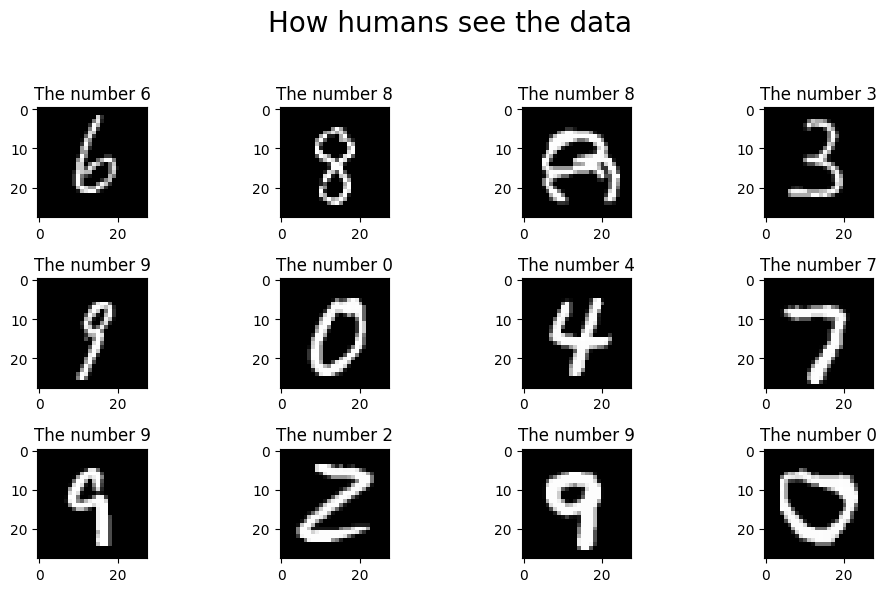

In [5]:
_, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
    image_to_show = np.random.randint(0, high=data.shape[0])
    image = np.reshape(X[image_to_show, :], (28, 28))
    
    ax.imshow(image, cmap='gray')
    ax.set_title("The number %i" %y[image_to_show])
    
plt.suptitle("How humans see the data", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

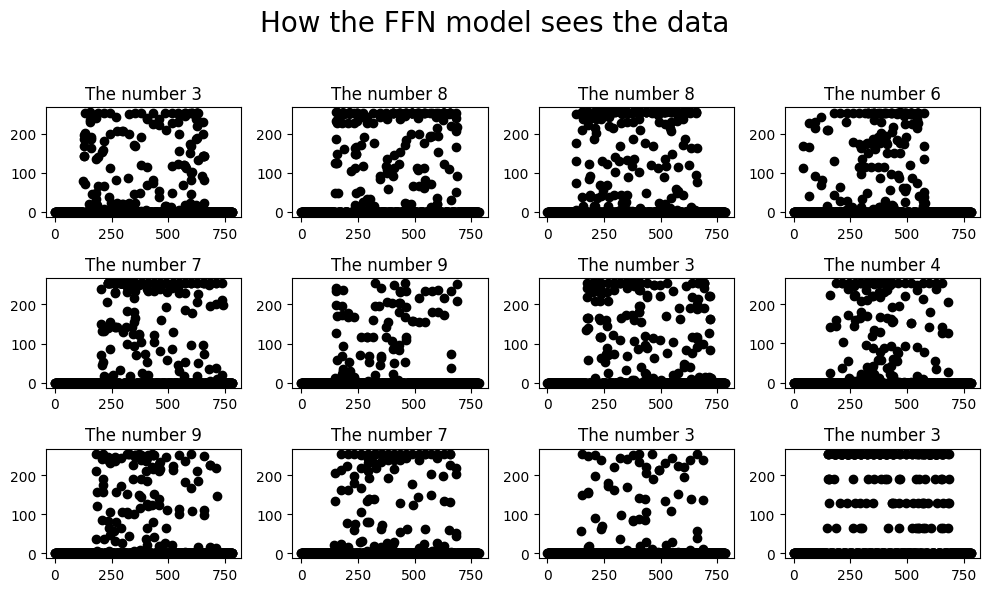

In [6]:
_, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
    image_to_show = np.random.randint(0, high=data.shape[0])
    
    ax.plot(X[image_to_show, :], 'ko')
    ax.set_title("The number %i" %y[image_to_show])
    
plt.suptitle("How the FFN model sees the data", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

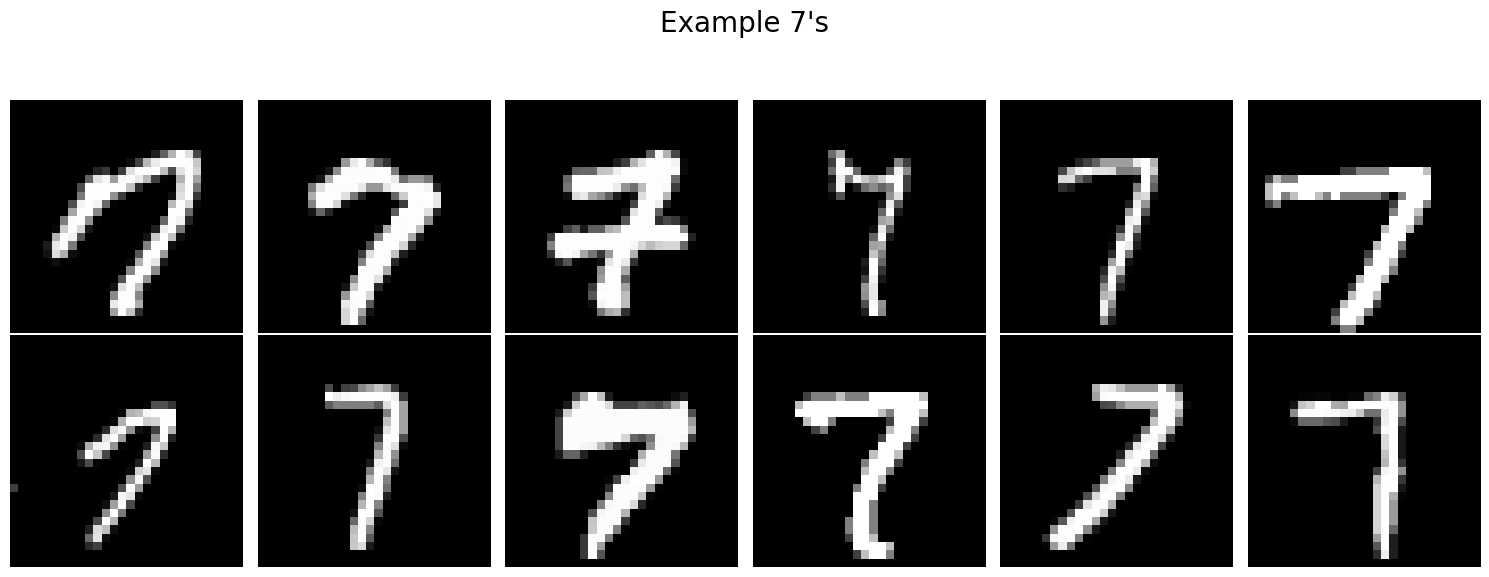

In [7]:
sevens = np.where(y == 7)[0]
_, axs = plt.subplots(2, 6, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    image = np.reshape(X[sevens[i], :], (28, 28))
    
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    
plt.suptitle("Example 7's", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

(2126, 784)


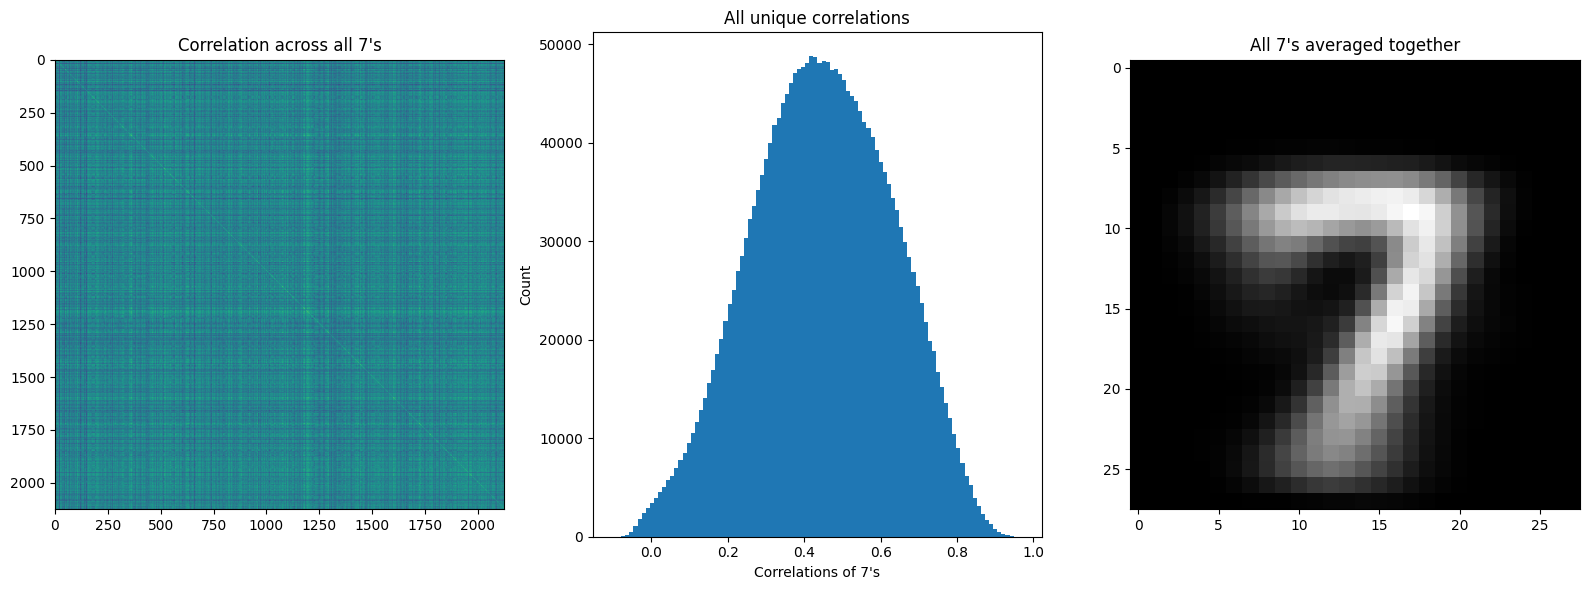

In [8]:
print(X[sevens, :].shape)

correlations = np.corrcoef(X[sevens, :])

_, ax = plt.subplots(1, 3, figsize=(16, 6))

ax[0].imshow(correlations, vmin=0, vmax=1)
ax[0].set_title("Correlation across all 7's")

unique_correlations = np.triu(correlations, k=1).flatten()

ax[1].hist(unique_correlations[unique_correlations != 0], bins=100)
ax[1].set_title("All unique correlations")
ax[1].set_xlabel("Correlations of 7's")
ax[1].set_ylabel('Count')

average_sevens = np.reshape(np.mean(X[sevens, :], axis=0), (28, 28))

ax[2].imshow(average_sevens, cmap='gray')
ax[2].set_title("All 7's averaged together")

plt.tight_layout()
plt.show()

## FFN to classify digits

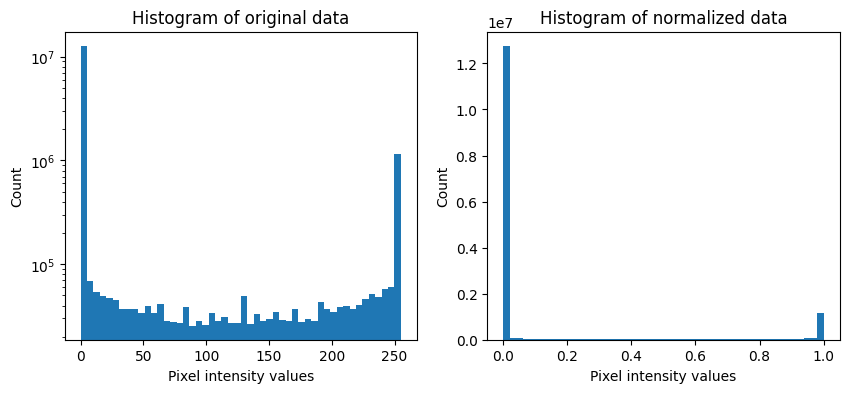

In [9]:
X_norm = X / np.max(X)

_, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(data.flatten(), 50)
ax[0].set_yscale('log')
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel('Count')
ax[0].set_title("Histogram of original data")

ax[1].hist(X_norm.flatten(), 50)
ax[1].set_xlabel("Pixel intensity values")
ax[1].set_ylabel('Count')
ax[1].set_title("Histogram of normalized data")

plt.show()

In [10]:
X_tensor = torch.tensor(X_norm).float()
y_tensor = torch.tensor(y).long()

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=.1)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [11]:
def create_model():
    class AnnMnist(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784, 64)
            self.fully_connected_1 = nn.Linear(64, 32)
            self.fully_connected_2 = nn.Linear(32, 32)
            self.output = nn.Linear(32, 10)
            
        def forward(self, x_param):
            x_local = self.input(x_param)
            x_local = F.relu(x_local)
            x_local = self.fully_connected_1(x_local)
            x_local = F.relu(x_local)
            x_local = self.fully_connected_2(x_local)
            x_local = F.relu(x_local)
            x_local = self.output(x_local)
            x_local = torch.log_softmax(x_local, axis=1)
            
            return x_local
    
    ann_mnist_local = AnnMnist()
    loss_function_local = nn.NLLLoss()
    optimizer_local = torch.optim.SGD(ann_mnist_local.parameters(), lr=.01)
    
    return ann_mnist_local, loss_function_local, optimizer_local

In [12]:
def train_model(model_param, loss_fun_param, optimizer_param, epochs_param):
     train_accuracies_local = []
     test_accuracies_local = []
     losses_local = []
     
     for epoch in range(epochs_param):
          batch_accuracies = []
          batch_losses = []
         
          model_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = model_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
               
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())

          train_accuracies_local.append(np.mean(batch_accuracies))
          losses_local.append(np.mean(batch_losses))
    
          model_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          
          with torch.no_grad():
               y_pred = model_param(X_local)
          
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local, losses_local

In [13]:
epochs = 60
ann_mnist, loss_function, optimizer = create_model()
train_accuracies, test_accuracies, losses = train_model(ann_mnist, loss_function, optimizer, epochs)

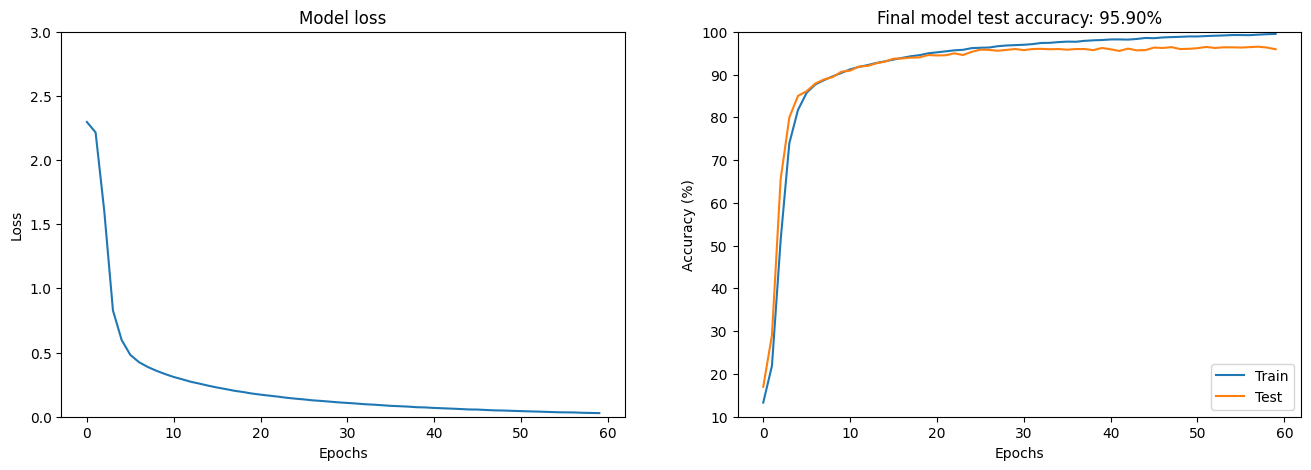

In [14]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(train_accuracies, label='Train')
ax[1].plot(test_accuracies, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {test_accuracies[-1]:.2f}%")
ax[1].legend()

plt.show()

In [15]:
X_first, y_first = next(iter(test_loader))
y_pred = ann_mnist(X_first).detach()

y_pred

tensor([[-1.1521e+01, -8.9265e+00, -1.4833e+01,  ..., -2.1495e+01,
         -1.1774e+01, -1.9932e+01],
        [-2.8736e+01, -2.0515e+01, -2.2562e+01,  ..., -2.7747e+01,
         -4.2915e-06, -1.4528e+01],
        [-1.6835e+01, -1.9358e+01, -1.7751e+01,  ..., -7.3602e+00,
         -1.2712e+01, -7.2024e-04],
        ...,
        [-1.5974e+01, -1.7676e+01, -1.4296e+01,  ..., -6.1989e-06,
         -1.9023e+01, -1.2155e+01],
        [-2.5724e-02, -1.2395e+01, -3.8961e+00,  ..., -8.9414e+00,
         -8.8856e+00, -7.6316e+00],
        [-3.0380e+01, -8.5883e+00, -2.4149e-04,  ..., -2.2205e+01,
         -1.3815e+01, -4.3790e+01]])

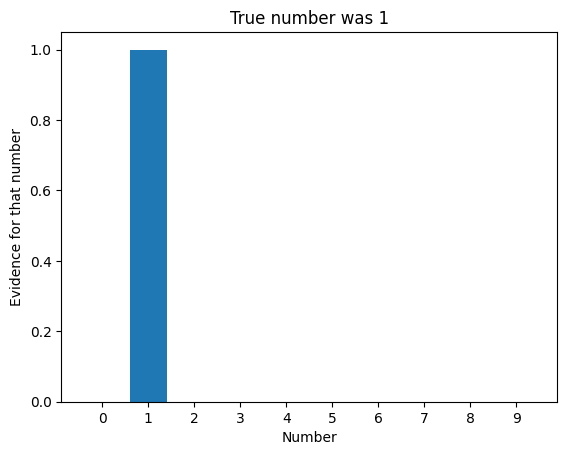

In [16]:
sample = 120

plt.bar(range(10), torch.exp(y_pred[sample]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel("Evidence for that number")
plt.title("True number was %s" %y_first[sample].item())
plt.show()

In [17]:
errors = np.where(torch.max(y_pred, axis=1)[1] != y_first)[0]

print(errors)

[  29   65   79   80  142  154  243  259  300  365  411  453  463  490
  525  535  622  662  695  746  753  824  846  847  848  853  871  882
  887  895  912  924  926  960  967  969  978  979 1039 1059 1077 1121
 1167 1232 1247 1272 1309 1325 1334 1336 1352 1365 1413 1433 1450 1458
 1481 1507 1512 1549 1574 1583 1627 1648 1710 1728 1741 1753 1767 1791
 1795 1829 1859 1889 1903 1904 1923 1926 1935 1946 1961 1979]


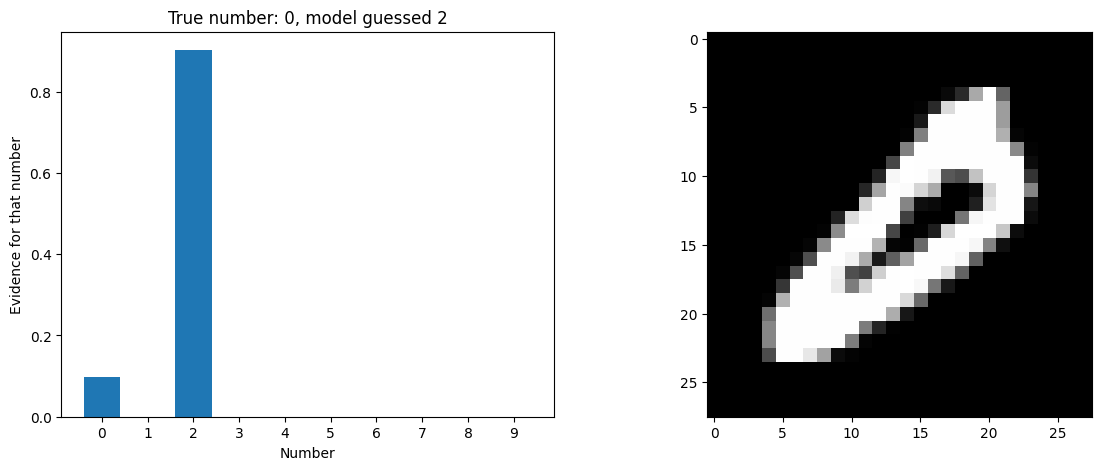

In [18]:
sample = 4
true_number = y_first[errors[sample]].item()
model_guessed = torch.argmax(y_pred[errors[sample]]).item()

_, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(y_pred[errors[sample]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel("Evidence for that number")
ax[0].set_title("True number: %s, model guessed %s" %(true_number, model_guessed))

ax[1].imshow(np.reshape(X_first[errors[sample], :], (28, 28)), cmap='gray')

plt.show()

## CodeChallenge: Binarized MNIST images

In [19]:
X_bin = X.copy()
X_bin[X_bin > 0] = 1

In [20]:
np.unique(X)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [21]:
np.unique(X_bin)

array([0., 1.])

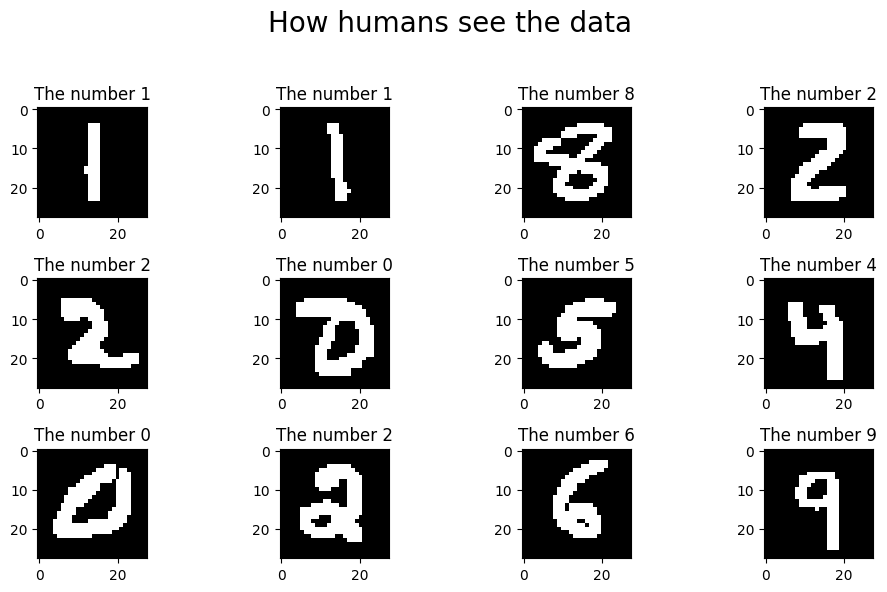

In [22]:
_, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
    image_to_show = np.random.randint(0, high=data.shape[0])
    image = np.reshape(X_bin[image_to_show, :], (28, 28))
    
    ax.imshow(image, cmap='gray')
    ax.set_title("The number %i" %y[image_to_show])
    
plt.suptitle("How humans see the data", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

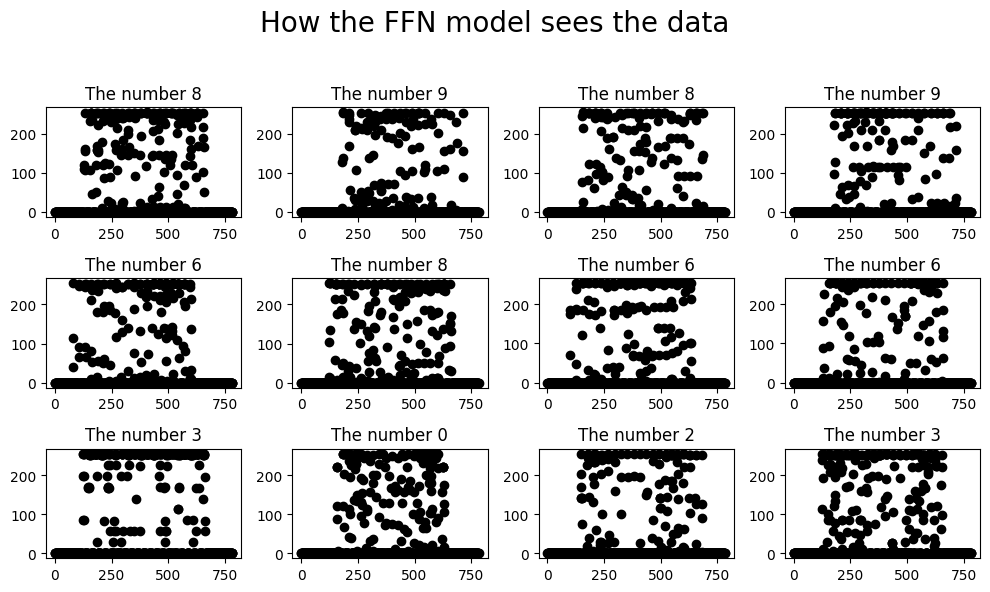

In [23]:
_, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
    image_to_show = np.random.randint(0, high=data.shape[0])
    
    ax.plot(X[image_to_show, :], 'ko')
    ax.set_title("The number %i" %y[image_to_show])
    
plt.suptitle("How the FFN model sees the data", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

In [24]:
X_tensor = torch.tensor(X_bin).float()
y_tensor = torch.tensor(y).long()

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=.1)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [25]:
epochs = 60
ann_mnist, loss_function, optimizer = create_model()
train_accuracies, test_accuracies, losses = train_model(ann_mnist, loss_function, optimizer, epochs)

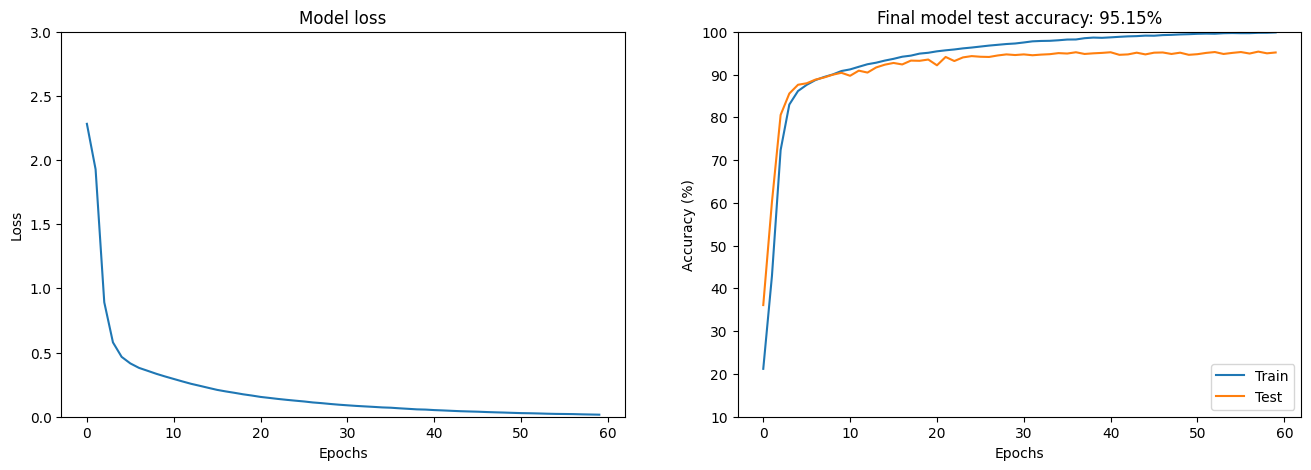

In [26]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(train_accuracies, label='Train')
ax[1].plot(test_accuracies, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {test_accuracies[-1]:.2f}%")
ax[1].legend()

plt.show()

## CodeChallenge: Data normalization

In [27]:
def train_model(model_param, loss_fun_param, optimizer_param, epochs_param):
     train_accuracies_local = []
     test_accuracies_local = []
     train_losses_local = []
     test_losses_local = []
     
     for epoch in range(epochs_param):
          batch_accuracies = []
          batch_losses = []
         
          model_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = model_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
               
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())

          train_accuracies_local.append(np.mean(batch_accuracies))
          train_losses_local.append(np.mean(batch_losses))
    
          model_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          
          with torch.no_grad():
               y_pred = model_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
            
               test_losses_local.append(loss.item())
          
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local, train_losses_local, test_losses_local

Training data range 0 to 1
Test data range 0 to 1


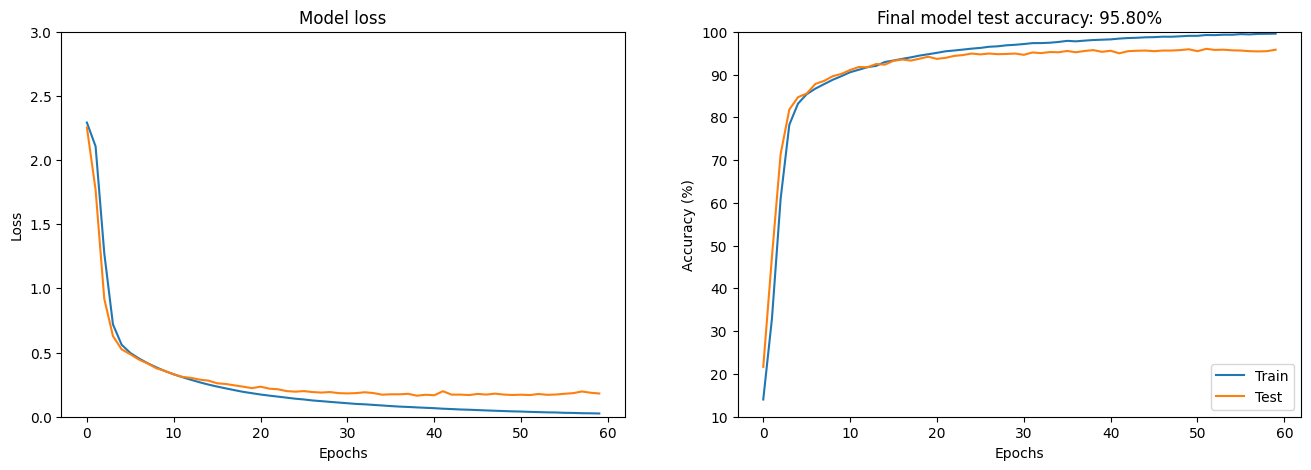

In [28]:
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).long()

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=.1)

X_y_train = TensorDataset(X_train / torch.max(X_train), y_train)
X_y_test = TensorDataset(X_test / torch.max(X_test), y_test)

batch_size = 32
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

print("Training data range %g to %g" %(torch.min(train_loader.dataset.tensors[0]), torch.max(train_loader.dataset.tensors[0])))
print("Test data range %g to %g" %(torch.min(test_loader.dataset.tensors[0]), torch.max(test_loader.dataset.tensors[0])))

epochs = 60
ann_mnist, loss_function, optimizer = create_model()
train_accuracies, test_accuracies, train_losses, test_losses = train_model(ann_mnist, loss_function, optimizer, epochs)

_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_losses, label='Train')
ax[0].plot(test_losses, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(train_accuracies, label='Train')
ax[1].plot(test_accuracies, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {test_accuracies[-1]:.2f}%")
ax[1].legend()

plt.show()

Training data range 0 to 1
Test data range 0 to 255


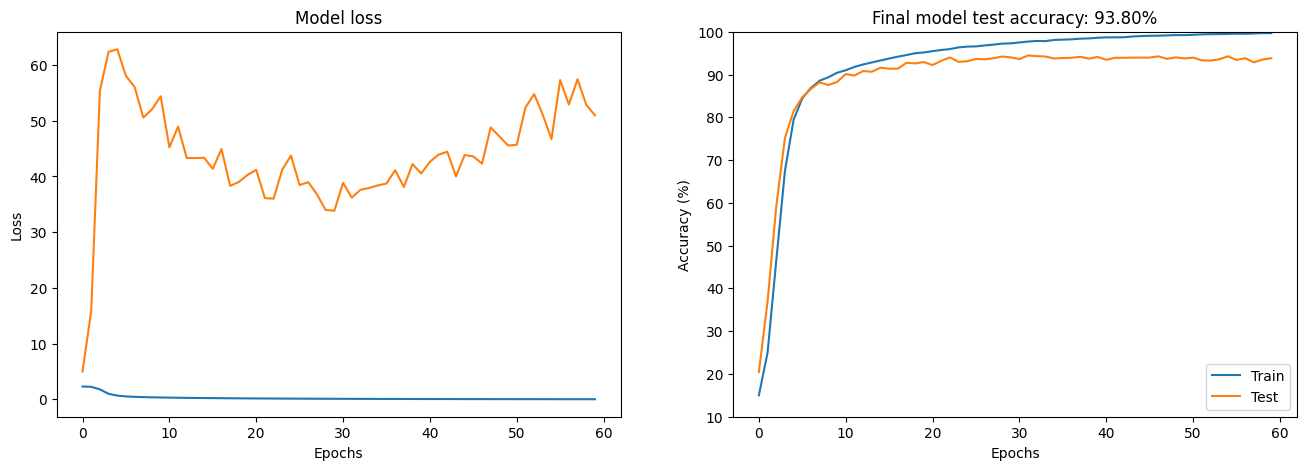

In [29]:
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).long()

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=.1)

X_y_train = TensorDataset(X_train / torch.max(X_train), y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

print("Training data range %g to %g" %(torch.min(train_loader.dataset.tensors[0]), torch.max(train_loader.dataset.tensors[0])))
print("Test data range %g to %g" %(torch.min(test_loader.dataset.tensors[0]), torch.max(test_loader.dataset.tensors[0])))

epochs = 60
ann_mnist, loss_function, optimizer = create_model()
train_accuracies, test_accuracies, train_losses, test_losses = train_model(ann_mnist, loss_function, optimizer, epochs)

_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_losses, label='Train')
ax[0].plot(test_losses, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title("Model loss")

ax[1].plot(train_accuracies, label='Train')
ax[1].plot(test_accuracies, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {test_accuracies[-1]:.2f}%")
ax[1].legend()

plt.show()

Training data range 0 to 255
Test data range 0 to 1


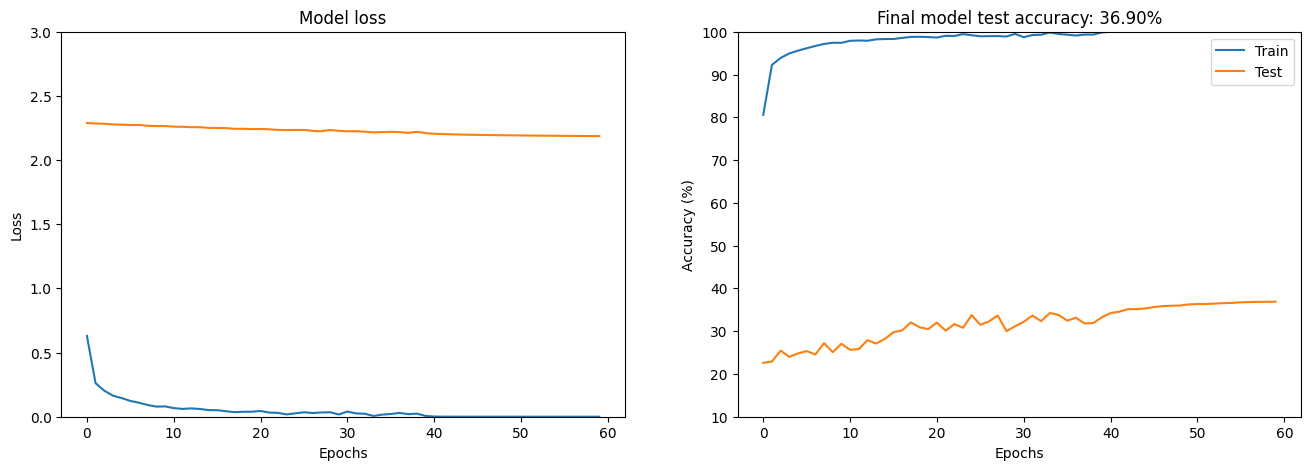

In [30]:
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).long()

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=.1)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test / torch.max(X_test), y_test)

batch_size = 32
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

print("Training data range %g to %g" %(torch.min(train_loader.dataset.tensors[0]), torch.max(train_loader.dataset.tensors[0])))
print("Test data range %g to %g" %(torch.min(test_loader.dataset.tensors[0]), torch.max(test_loader.dataset.tensors[0])))

epochs = 60
ann_mnist, loss_function, optimizer = create_model()
train_accuracies, test_accuracies, train_losses, test_losses = train_model(ann_mnist, loss_function, optimizer, epochs)

_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_losses, label='Train')
ax[0].plot(test_losses, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(train_accuracies, label='Train')
ax[1].plot(test_accuracies, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {test_accuracies[-1]:.2f}%")
ax[1].legend()

plt.show()

## Distributions of weights pre- and post-learning

In [31]:
X_tensor = torch.tensor(X / np.max(X)).float()
y_tensor = torch.tensor(y).long()

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=.1)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [32]:
ann_mnist, _, _ = create_model()

In [33]:
print("Summary of model:")
print(ann_mnist)
print()

Summary of model:
AnnMnist(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fully_connected_1): Linear(in_features=64, out_features=32, bias=True)
  (fully_connected_2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)



In [34]:
print("Summary of input layer:")
print(vars(ann_mnist.input))
print()

Summary of input layer:
{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([[-0.0156, -0.0004,  0.0116,  ..., -0.0163, -0.0305,  0.0248],
        [-0.0324, -0.0255, -0.0269,  ..., -0.0123,  0.0058,  0.0211],
        [ 0.0045,  0.0354,  0.0234,  ...,  0.0328, -0.0153, -0.0005],
        ...,
        [ 0.0033,  0.0170,  0.0151,  ...,  0.0090, -0.0189,  0.0100],
        [-0.0076,  0.0223, -0.0210,  ...,  0.0019, -0.0215,  0.0075],
        [-0.0187, -0.0169,  0.0096,  ...,  0.0078, -0.0130,  0.0074]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.0173, -0.0114, -0.0299,  0.0233, -0.0244, -0.0188, -0.0134, -0.0182,
         0.0157, -0.0180,  0.0179, -0.0299, -0.0220, -0.0261,  0.0097, -0.0040,
        -0.0146,  0.0003,  0.0200, -0.0288, -0.0031,  0.0263,  0.0109, -0.0147,
        -0.0081, -0.0163, -0.0139, -0.0153, -0.0167,  0.0208, -0.0235, -0.0064,
        -0.0269,  0.0048, -0.0198,  0.0139,  0.0220, -0.0259, -0.0115, -0.0016,
  

In [35]:
print("Input layer weights:")
print(ann_mnist.input.weight.shape)
print(ann_mnist.input.weight)
print()

Input layer weights:
torch.Size([64, 784])
Parameter containing:
tensor([[-0.0156, -0.0004,  0.0116,  ..., -0.0163, -0.0305,  0.0248],
        [-0.0324, -0.0255, -0.0269,  ..., -0.0123,  0.0058,  0.0211],
        [ 0.0045,  0.0354,  0.0234,  ...,  0.0328, -0.0153, -0.0005],
        ...,
        [ 0.0033,  0.0170,  0.0151,  ...,  0.0090, -0.0189,  0.0100],
        [-0.0076,  0.0223, -0.0210,  ...,  0.0019, -0.0215,  0.0075],
        [-0.0187, -0.0169,  0.0096,  ...,  0.0078, -0.0130,  0.0074]],
       requires_grad=True)



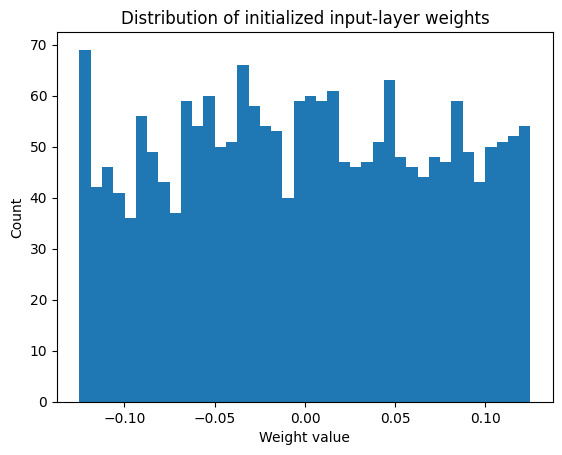

In [36]:
weights = ann_mnist.fully_connected_1.weight.detach().flatten()

plt.hist(weights, 40)
plt.xlabel("Weight value")
plt.ylabel('Count')
plt.title("Distribution of initialized input-layer weights")
plt.show()

In [37]:
def get_weights_histogram(model_param):
    weights_local = np.array([])
    
    for layer in model_param.parameters():
        weights_local = np.concatenate((weights_local, layer.detach().flatten().numpy()))
        
    histogram_y_local, histogram_x_local = np.histogram(weights_local, bins=np.linspace(-.8, .8, 101), density=True)
    histogram_x_local = (histogram_x_local[1:] + histogram_x_local[:-1]) / 2
    
    return histogram_x_local, histogram_y_local

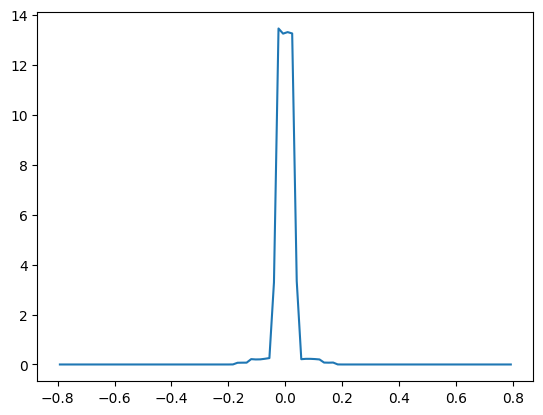

In [38]:
histogram_x, histogram_y = get_weights_histogram(ann_mnist)

plt.plot(histogram_x, histogram_y)
plt.show()

In [39]:
def train_model(model_param, loss_fun_param, optimizer_param, epochs_param):
     train_accuracies_local = []
     test_accuracies_local = []
     losses_local = []
     histogram_x_local = np.zeros((epochs_param, 100))
     histogram_y_local = np.zeros((epochs_param, 100))
     
     for epoch in range(epochs_param):
          histogram_x_local, histogram_y_local[epoch, :] = get_weights_histogram(ann_mnist)
          batch_accuracies = []
          batch_losses = []
         
          model_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = model_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
               
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())

          train_accuracies_local.append(np.mean(batch_accuracies))
          losses_local.append(np.mean(batch_losses))
    
          model_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          
          with torch.no_grad():
               y_pred = model_param(X_local)
          
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local, losses_local, histogram_x_local, histogram_y_local

In [40]:
epochs = 100
ann_mnist, loss_function, optimizer = create_model()
train_accuracies, test_accuracies, losses, histogram_x, histogram_y = train_model(ann_mnist, loss_function, optimizer, epochs)

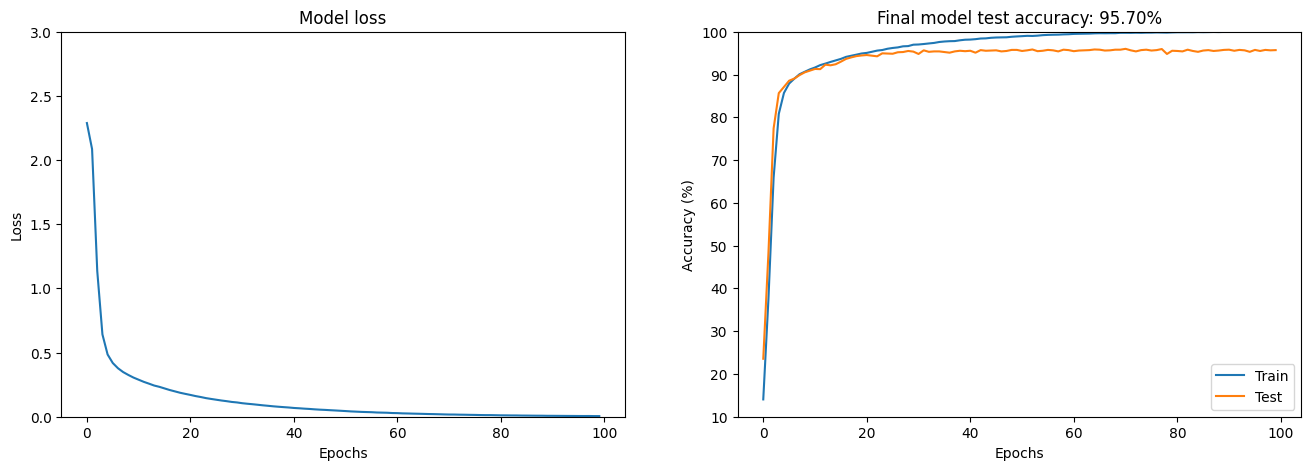

In [41]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(train_accuracies, label='Train')
ax[1].plot(test_accuracies, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {test_accuracies[-1]:.2f}%")
ax[1].legend()

plt.show()

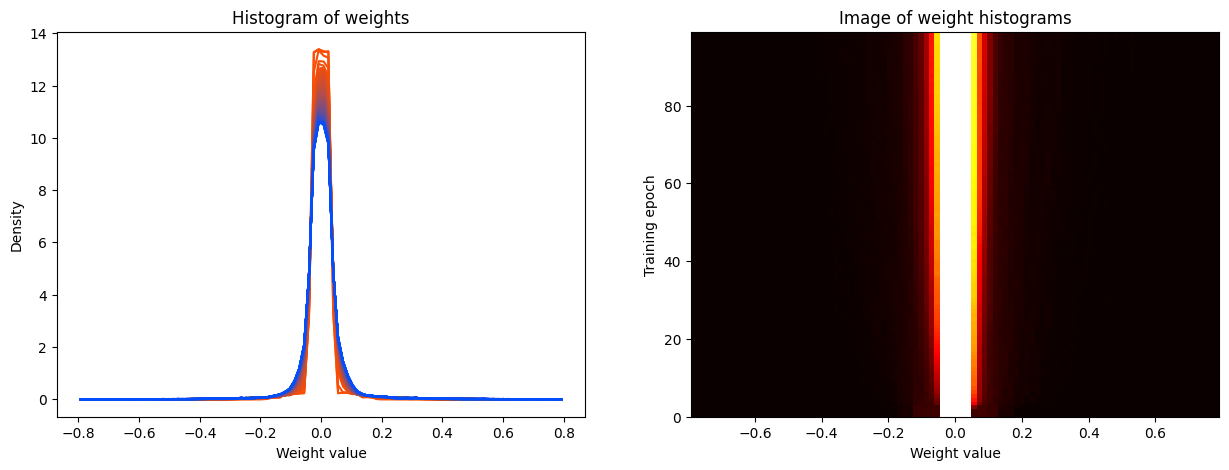

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(histogram_y.shape[0]):
    ax[0].plot(histogram_x, histogram_y[i, :], color=[1 - i / 100, .3, i / 100])
    
ax[0].set_title("Histogram of weights")
ax[0].set_xlabel("Weight value")
ax[0].set_ylabel('Density')

ax[1].imshow(histogram_y, vmin=0, vmax=3, extent=[histogram_x[0], histogram_x[-1], 0, 99], aspect='auto', origin='lower', cmap='hot')
ax[1].set_xlabel("Weight value")
ax[1].set_ylabel("Training epoch")
ax[1].set_title("Image of weight histograms")

plt.show()

## CodeChallenge: MNIST and breadth vs. depth

In [43]:
def create_model(units_param, layers_param):
    class AnnMnist(nn.Module):
        def __init__(self, units_model_param, layers_model_param):
            super().__init__()
            
            self.layers = nn.ModuleDict()
            self.layers_nr = layers_model_param
            self.layers['input'] = nn.Linear(784, units_model_param)
            
            for layer_model in range(layers_model_param):
                self.layers[f'hidden_{layer_model}'] = nn.Linear(units_model_param, units_model_param)
                
            self.layers['output'] = nn.Linear(units_model_param, 10)
            
        def forward(self, x_param):
            x_local = F.relu(self.layers['input'](x_param))
            
            for layer_nr in range(self.layers_nr):
                x_local = F.relu(self.layers[f'hidden_{layer_nr}'](x_local))
                
            x_local = self.layers['output'](x_local)
            x_local = torch.log_softmax(x_local, axis=1)
            
            return x_local
    
    ann_mnist_local = AnnMnist(units_param, layers_param)
    loss_function_local = nn.NLLLoss()
    optimizer_local = torch.optim.SGD(ann_mnist_local.parameters(), lr=.01)
    
    return ann_mnist_local, loss_function_local, optimizer_local

In [44]:
def train_model(model_param, loss_fun_param, optimizer_param, epochs_param):
     train_accuracies_local = []
     test_accuracies_local = []
     losses_local = []
     
     for epoch in range(epochs_param):
          batch_accuracies = []
          batch_losses = []
         
          model_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = model_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
               
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())

          train_accuracies_local.append(np.mean(batch_accuracies))
          losses_local.append(np.mean(batch_losses))
    
          model_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          
          with torch.no_grad():
               y_pred = model_param(X_local)
          
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local, losses_local

In [45]:
units = np.arange(50, 251, 50)
layers = [1, 2, 3]   
accuracies  = np.zeros((2, len(units), len(layers)))
epochs = 60

for unit_i, unit in enumerate(units):
    for layer_j, layer in enumerate(layers):
        ann_mnist, loss_function, optimizer = create_model(unit, layer)
        train_accuracies, test_accuracies, _ = train_model(ann_mnist, loss_function, optimizer, epochs)
        accuracies[0, unit_i, layer_j] = np.mean(train_accuracies[-5:])
        accuracies[1, unit_i, layer_j] = np.mean(test_accuracies[-5:])
        
        print(f"Finished units {unit_i + 1}/{len(units)} and layers {layer_j + 1}/{len(layers)}") 

Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


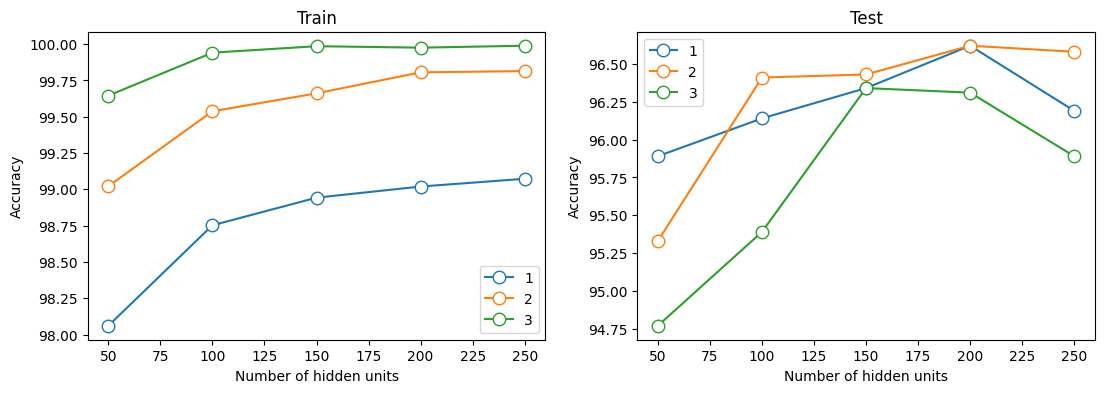

In [46]:
_, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(units, accuracies[0, :, :], 'o-', markerfacecolor='w', markersize=9)
ax[0].legend(layers)
ax[0].set_xlabel("Number of hidden units")
ax[0].set_ylabel('Accuracy')
ax[0].set_title("Train")

ax[1].plot(units, accuracies[1, :, :], 'o-', markerfacecolor='w', markersize=9)
ax[1].legend(layers)
ax[1].set_xlabel("Number of hidden units")
ax[1].set_ylabel('Accuracy')
ax[1].set_title("Test")

plt.show()

## CodeChallenge: Optimizers and MNIST

In [47]:
def create_model(optimizer_name_param, learning_rate_param):
    class AnnMnist(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784, 64)
            self.fully_connected_1 = nn.Linear(64, 32)
            self.fully_connected_2 = nn.Linear(32, 32)
            self.output = nn.Linear(32, 10)
            
        def forward(self, x_param):
            x_local = self.input(x_param)
            x_local = F.relu(x_local)
            x_local = self.fully_connected_1(x_local)
            x_local = F.relu(x_local)
            x_local = self.fully_connected_2(x_local)
            x_local = F.relu(x_local)
            x_local = self.output(x_local)
            x_local = torch.log_softmax(x_local, axis=1)
            
            return x_local
    
    ann_mnist_local = AnnMnist()
    loss_function_local = nn.NLLLoss()
    optimizer_function = getattr(torch.optim, optimizer_name_param)
    optimizer_local = optimizer_function(ann_mnist_local.parameters(), lr=learning_rate_param)
    
    return ann_mnist_local, loss_function_local, optimizer_local

In [48]:
optimizer_names = ['SGD', 'RMSprop', 'Adam']
learning_rates = np.logspace(-4, -1, 6)
test_accuracy_results  = np.zeros((len(optimizer_names), len(learning_rates)))
epochs = 60

for optimizer_name_i, optimizer_name in enumerate(optimizer_names):
    for learning_rate_j, learning_rate in enumerate(learning_rates):
        ann_mnist, loss_function, optimizer = create_model(optimizer_name, learning_rate)
        _, test_accuracies, _ = train_model(ann_mnist, loss_function, optimizer, epochs)
        test_accuracy_results[optimizer_name_i, learning_rate_j] = np.mean(test_accuracies[-10:])
        
        print(f"Finished optimizers {optimizer_name_i + 1}/{len(optimizer_names)} and learning rates {learning_rate_j + 1}/{len(learning_rates)}")

Finished optimizers 1/3 and learning rates 1/6
Finished optimizers 1/3 and learning rates 2/6
Finished optimizers 1/3 and learning rates 3/6
Finished optimizers 1/3 and learning rates 4/6
Finished optimizers 1/3 and learning rates 5/6
Finished optimizers 1/3 and learning rates 6/6
Finished optimizers 2/3 and learning rates 1/6
Finished optimizers 2/3 and learning rates 2/6
Finished optimizers 2/3 and learning rates 3/6
Finished optimizers 2/3 and learning rates 4/6
Finished optimizers 2/3 and learning rates 5/6
Finished optimizers 2/3 and learning rates 6/6
Finished optimizers 3/3 and learning rates 1/6
Finished optimizers 3/3 and learning rates 2/6
Finished optimizers 3/3 and learning rates 3/6
Finished optimizers 3/3 and learning rates 4/6
Finished optimizers 3/3 and learning rates 5/6
Finished optimizers 3/3 and learning rates 6/6


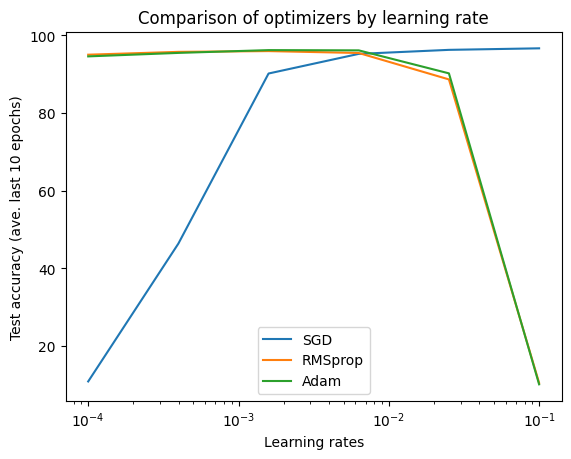

In [49]:
plt.plot(learning_rates, test_accuracy_results.T)
plt.legend(optimizer_names)
plt.xscale('log')
plt.xlabel("Learning rates")
plt.ylabel("Test accuracy (ave. last 10 epochs)")
plt.title("Comparison of optimizers by learning rate")
plt.show()

## Scrambled MNIST

In [50]:
X_norm = X / np.max(X)
scrambled_indexes = np.random.permutation(X.shape[1])
X_scrambled = X_norm[:, scrambled_indexes]

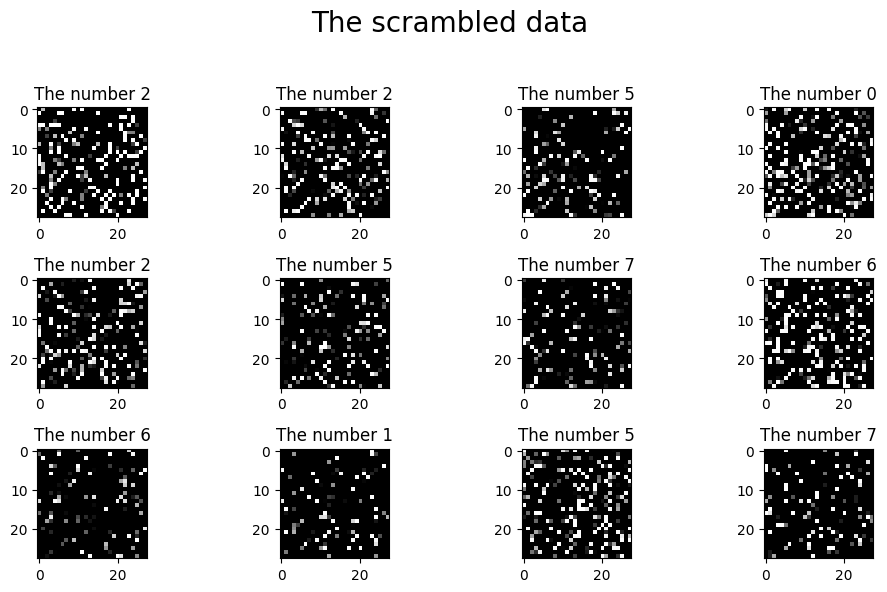

In [51]:
_, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
    image_to_show = np.random.randint(0, high=data.shape[0])
    image = np.reshape(X_scrambled[image_to_show, :], (28, 28))
    
    ax.imshow(image, cmap='gray')
    ax.set_title("The number %i" %y[image_to_show])
    
plt.suptitle("The scrambled data", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

In [52]:
X_tensor = torch.tensor(X_scrambled).float()
y_tensor = torch.tensor(y).long()

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=.1)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [53]:
def create_model():
    class AnnMnist(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784, 64)
            self.fully_connected_1 = nn.Linear(64, 32)
            self.fully_connected_2 = nn.Linear(32, 32)
            self.output = nn.Linear(32, 10)
            
        def forward(self, x_param):
            x_local = self.input(x_param)
            x_local = F.relu(x_local)
            x_local = self.fully_connected_1(x_local)
            x_local = F.relu(x_local)
            x_local = self.fully_connected_2(x_local)
            x_local = F.relu(x_local)
            x_local = self.output(x_local)
            x_local = torch.log_softmax(x_local, axis=1)
            
            return x_local
    
    ann_mnist_local = AnnMnist()
    loss_function_local = nn.NLLLoss()
    optimizer_local = torch.optim.SGD(ann_mnist_local.parameters(), lr=.01)
    
    return ann_mnist_local, loss_function_local, optimizer_local

In [54]:
def train_model(model_param, loss_fun_param, optimizer_param, epochs_param):
     train_accuracies_local = []
     test_accuracies_local = []
     losses_local = []
     
     for epoch in range(epochs_param):
          batch_accuracies = []
          batch_losses = []
         
          model_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = model_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
               
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())

          train_accuracies_local.append(np.mean(batch_accuracies))
          losses_local.append(np.mean(batch_losses))
    
          model_param.eval()
          
          X_local, y_local = next(iter(test_loader))
          
          with torch.no_grad():
               y_pred = model_param(X_local)
          
          correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
          
          test_accuracies_local.append(100 * torch.mean(correct_predictions).item())
     
     return train_accuracies_local, test_accuracies_local, losses_local

In [55]:
epochs = 60
ann_mnist, loss_function, optimizer = create_model()
train_accuracies, test_accuracies, losses = train_model(ann_mnist, loss_function, optimizer, epochs)

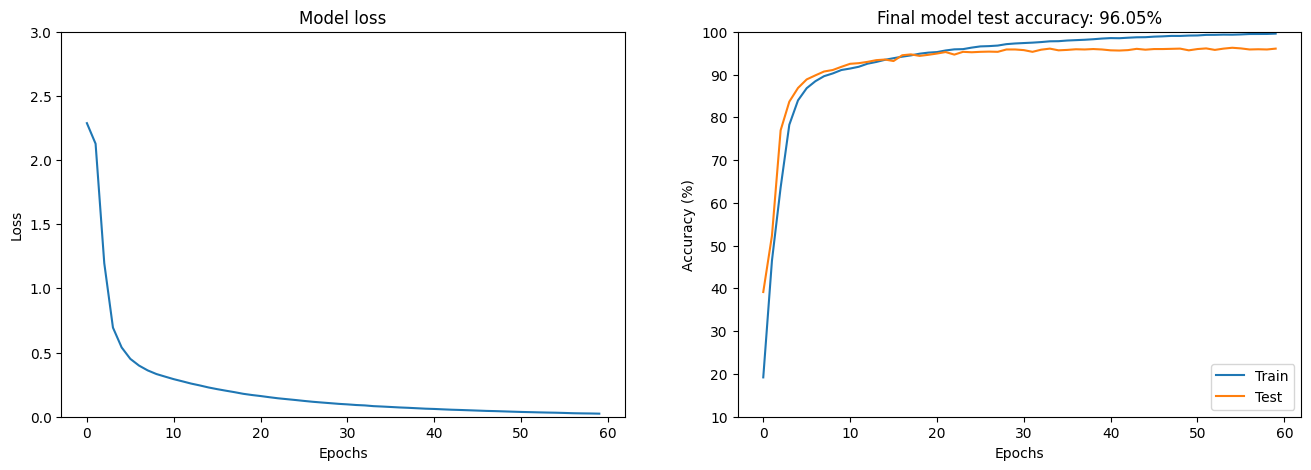

In [56]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(train_accuracies, label='Train')
ax[1].plot(test_accuracies, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {test_accuracies[-1]:.2f}%")
ax[1].legend()

plt.show()

## Shifted MNIST

In [57]:
X_tensor = torch.tensor(X_norm).float()
y_tensor = torch.tensor(y).long()

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=.1)

X_y_train = TensorDataset(X_train, y_train)
X_y_test = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

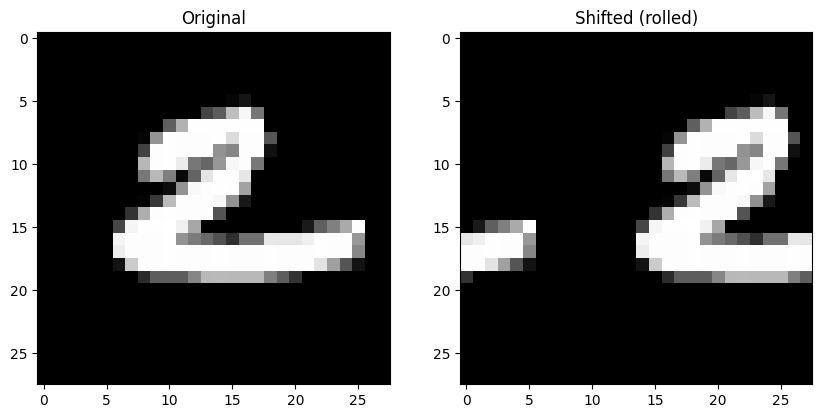

In [58]:
image = test_loader.dataset.tensors[0][0, :]
image = image.reshape(28, 28)

image_reshaped = torch.roll(image, 8, dims=1)

_, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(image_reshaped, cmap='gray')
ax[1].set_title("Shifted (rolled)")

plt.show()

In [59]:
for i in range(test_loader.dataset.tensors[0].shape[0]):
    image = test_loader.dataset.tensors[0][i, :]
    random_roll = np.random.randint(-10, 11)
    image = torch.roll(image.reshape(28, 28), random_roll, dims=1)
    
    test_loader.dataset.tensors[0][i, :] = image.reshape(1, -1)

In [60]:
epochs = 60
ann_mnist, loss_function, optimizer = create_model()
train_accuracies, test_accuracies, losses = train_model(ann_mnist, loss_function, optimizer, epochs)

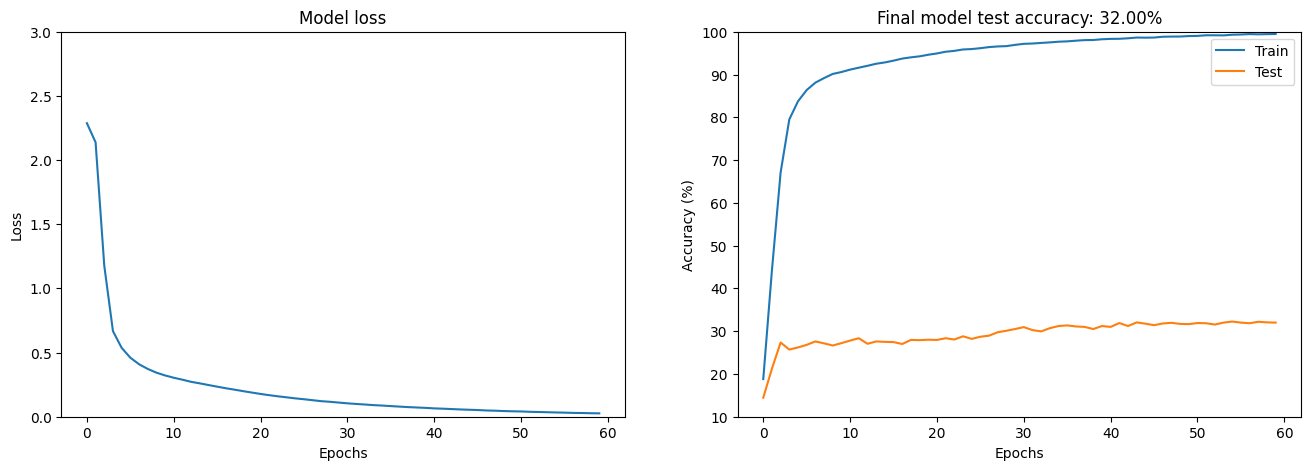

In [61]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(train_accuracies, label='Train')
ax[1].plot(test_accuracies, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {test_accuracies[-1]:.2f}%")
ax[1].legend()

plt.show()

## CodeChallenge: The mystery of the missing 7

In [62]:
X_norm = X / np.max(X)
seven_indexes = (y == 7)
X_seven = X[seven_indexes]
y_seven = y[seven_indexes]
X_without_seven = X[~seven_indexes]
y_without_seven = y[~seven_indexes]

In [63]:
X_y_train = TensorDataset(torch.tensor(X_without_seven, dtype=torch.float32), torch.tensor(y_without_seven, dtype=torch.long))
X_y_test = TensorDataset(torch.tensor(X_seven, dtype=torch.float32), torch.tensor(y_seven, dtype=torch.long))

batch_size = 32
train_loader = DataLoader(X_y_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [64]:
def train_model(model_param, loss_fun_param, optimizer_param, epochs_param):
     train_accuracies_local = []
     losses_local = []
     
     for epoch in range(epochs_param):
          batch_accuracies = []
          batch_losses = []
         
          model_param.train()
         
          for X_local, y_local in train_loader:
               y_pred = model_param(X_local)
               loss = loss_fun_param(y_pred, y_local)
               
               optimizer_param.zero_grad()
               loss.backward()
               optimizer_param.step()
               
               correct_predictions = (torch.argmax(y_pred, axis=1) == y_local).float()
             
               batch_accuracies.append(100 * torch.mean(correct_predictions).item())
               batch_losses.append(loss.item())

          train_accuracies_local.append(np.mean(batch_accuracies))
          losses_local.append(np.mean(batch_losses))
     
     return train_accuracies_local, losses_local

In [65]:
epochs = 60
ann_mnist, loss_function, optimizer = create_model()
train_accuracies, losses = train_model(ann_mnist, loss_function, optimizer, epochs)

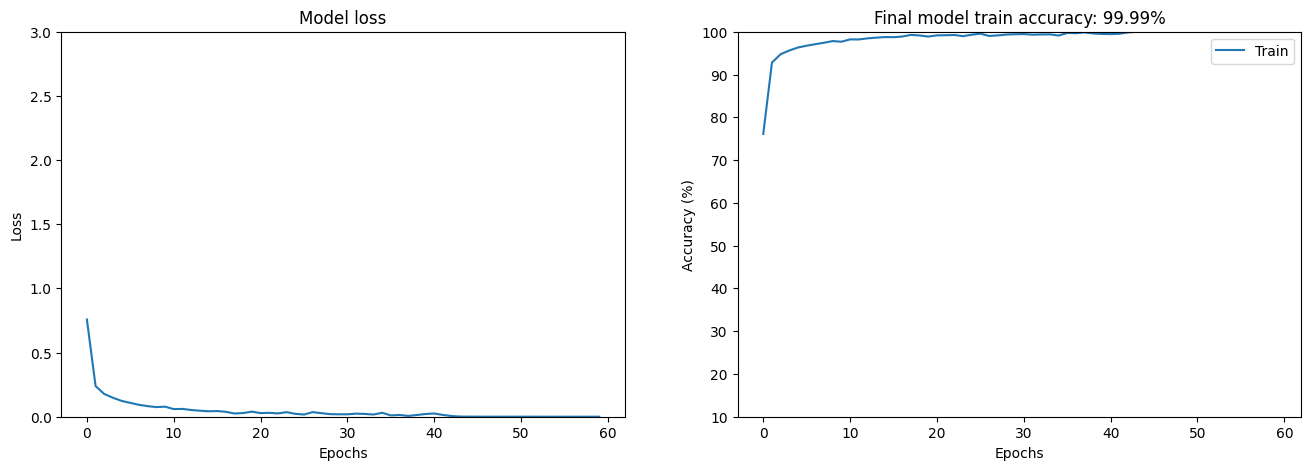

In [66]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(train_accuracies, label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model train accuracy: {train_accuracies[-1]:.2f}%")
ax[1].legend()

plt.show()

In [67]:
X_test = next(iter(test_loader))[0]
predictions = ann_mnist(X_test).detach()
y_pred = torch.argmax(predictions, axis=1).detach()

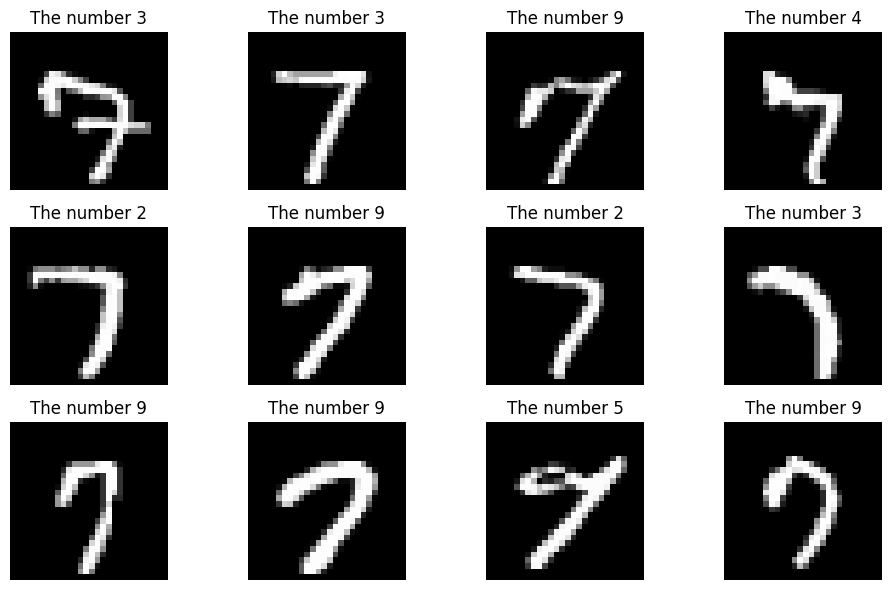

In [68]:
_, axs = plt.subplots(3, 4, figsize=(10, 6))

random_seven_indexes = np.random.choice(len(X_test), 12)

for i, ax in enumerate(axs.flatten()):
    image = X_test[random_seven_indexes[i]].view(28, 28)
    
    ax.imshow(image, cmap='gray')
    ax.set_title(f"The number {y_pred[random_seven_indexes[i]]}")
    ax.axis('off')
    
plt.tight_layout()
plt.show()

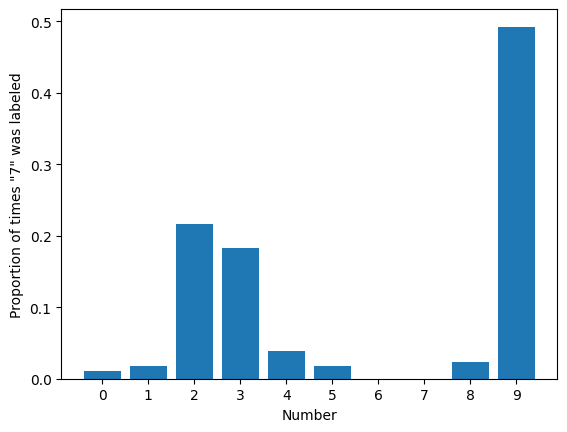

In [69]:
mistake_proportions = np.zeros(10)

for i in range(10):
    mistake_proportions[i] = torch.mean((y_pred == i).float())
    
plt.bar(range(10), mistake_proportions)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel("Proportion of times \"7\" was labeled")
plt.show()

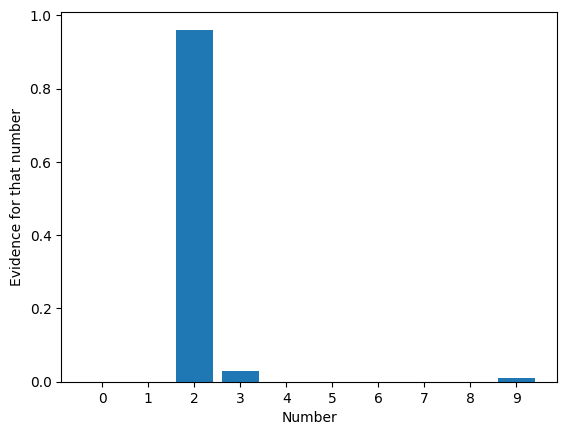

In [70]:
sample = 12

plt.bar(range(10), torch.exp(predictions[sample]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel("Evidence for that number")
plt.show()